In [76]:
import pyccl as ccl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import simps
from scipy.interpolate import interp1d
from importlib import reload
import cmasher as cmr
import multiprocessing as mp
import time
import os
import shutil
import CM_code.halo_model as halos 
import CM_code.spurious_george as sp
import pickle

reload(sp)
reload(halos)

year=10

zlmin, zlmax = 1.0, 1.2
zsmin, zsmax = 0.05, 3.5

cosmo = sp.zed.cosmo_SRD

out_plot = 'mbias_forecast_y%d_zs=%1.2f-%1.1f.png'%(year, zsmin, zsmax)

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

### Load in fiducial IA and lensing shears

In [77]:
Boost_dat = np.load('generated_data/boost_y%d_zs=0.05-%1.1f.npz'%(year,zsmax))
B_min1 = Boost_dat['B_min1']
r_p = Boost_dat['rp']

F_dat = np.load('generated_data/F_theta_y%d_zs=0.05-%1.1f.npz'%(year,zsmax))
F_theta = F_dat['F_theta']

cov_file = np.load('generated_data/y%d_covs_dense_%1.2f-%1.1f.npz'%(year, zsmin, zsmax))
rho = cov_file['rho']
covs = cov_file['covs']

for k in range(len(rho)):
    for i in range(len(r_p)):
        for j in range(len(r_p)):
            covs[k,i,j] = covs[k,i,j] / ((B_min1[i] + F_theta[i])*(B_min1[j] + F_theta[j]))

shear_file = np.load('generated_data/delM_yL_y%d_zs=%1.2f-%1.2f.npz'%(year,zsmin,zsmax))
IA_file = np.load('generated_data/yIA_y%d_zs=%1.2f-%1.2f.npz'%(year,zsmin,zsmax))

yIA = IA_file['yIA'] / (B_min1 + F_theta)
yL = shear_file['yL'] / (B_min1 + F_theta)

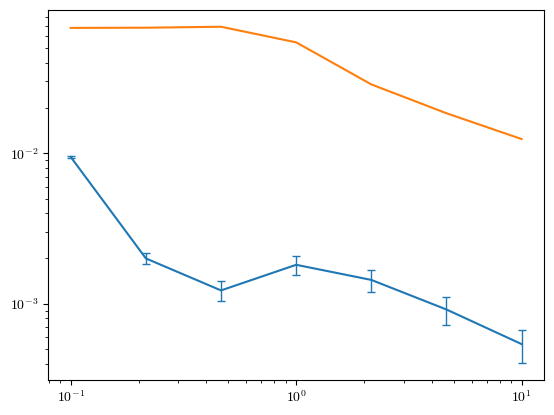

In [78]:
# check loaded data looks like the right thing
plt.errorbar(r_p, -yIA, np.sqrt(np.diag(covs[0])), elinewidth=1, capsize=3)
plt.loglog(r_p, yL)

### Draw multiplicative bias values from 1D gaussian

-0.00019200794856295906


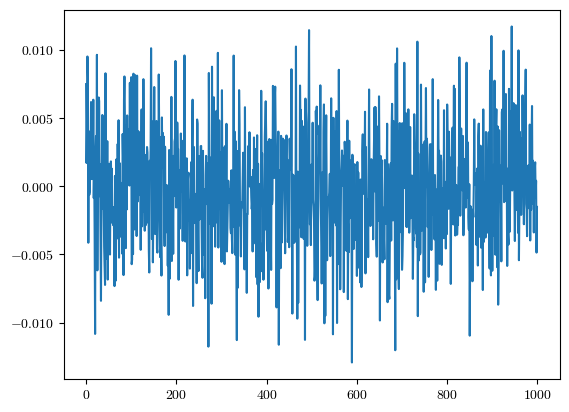

In [79]:
# mean is 0, 1 sigma uncertainty is 0.013
sampling = 1000

# set a seed so we draw the same values every time for when we re-run the code
np.random.seed(0)

if year==1:
    var=np.sqrt(0.013**2 + 0.013**2)
elif year==10:
    var=np.sqrt(0.003**2 + 0.003**2)

delM = np.random.normal(loc=0., scale=var, size=sampling)
# check draws look sensible
plt.plot(delM)
print(np.mean(delM))

### Now estimate covarainces for yL and yIA

In [80]:
# contruct lensing signals from random draws of residual bias
dm_yL = np.asarray([dm * yL for dm in delM])
mean_dm = np.mean(dm_yL, axis=0)

a_vals = np.linspace(0.9,0.1,9)

cov_IA = np.zeros([len(a_vals), len(rho), len(r_p), len(r_p)])
StoN = np.zeros([len(a_vals), len(rho)])
StoN_diag = np.zeros([len(a_vals), len(rho), len(r_p)])

for k, p in enumerate(rho):
    for l, a in enumerate(a_vals):
        a_yIA = (1-a)*yIA
        cov_T = covs[k]

        # need to set a seed so the random draw is the same for each loop iteration, only differing in a_yIA
        np.random.seed(0) 
        # contsruct "measured" signals by drawing from multivariate gaussian defined by cov_T and a_yIA + mean(dm_yL)#
        signal = np.random.multivariate_normal(mean=(a_yIA+mean_dm), cov=cov_T, size=sampling)
        mean_signal = np.mean(signal, axis=0)

        # calculate lensing covaraince from sampling
        cov_L = np.zeros([len(r_p),len(r_p)])
        for i, rp1 in enumerate(r_p):
            for j, rp2 in enumerate(r_p):
                    cov_L[i,j] = 1/(sampling-1) * np.sum((dm_yL[:,i] - mean_dm[i])*(dm_yL[:,j] - mean_dm[j]).T)

        # calculate cross covaraince of measured signal and residual lensing
        cov_L_T = np.zeros([len(r_p),len(r_p)])
        for i, rp1 in enumerate(r_p):
            for j, rp2 in enumerate(r_p):
                    cov_L_T[i,j] = 1/(sampling-1) * np.sum((dm_yL[:,i] - mean_dm[i])*(signal[:,j] - mean_signal[j]).T)
                    
        # calculate cross covaraince of measured signal and residual lensing
        cov_T_L = np.zeros([len(r_p),len(r_p)])
        for i, rp1 in enumerate(r_p):
            for j, rp2 in enumerate(r_p):
                    cov_T_L[i,j] = 1/(sampling-1) * np.sum((dm_yL[:,j] - mean_dm[j])*(signal[:,i] - mean_signal[i]).T)

        # combine covarainces to estimate IA only covariance 
        cov_IA[l,k] = cov_T + cov_L - cov_L_T - cov_T_L
        
        StoN[l,k] = np.sqrt(a_yIA @ np.linalg.inv(cov_IA[l,k]) @ a_yIA.T)
        StoN_diag[l,k,:] = -a_yIA / np.sqrt(np.diag(cov_IA[l,k]))

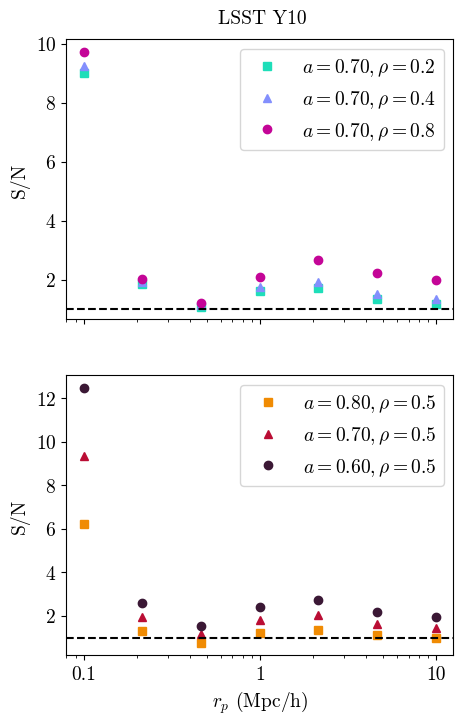

In [24]:
colors1 = cmr.take_cmap_colors('cmr.neon', 3, cmap_range=(0.80, 0.20), return_fmt='hex')
colors2 = cmr.take_cmap_colors('cmr.ember', 3, cmap_range=(0.80, 0.20), return_fmt='hex')

fig, (ax1, ax2) = plt.subplots(2,1, figsize=[5,8], sharex=True)

fig.text(0.43,0.9,'LSST Y%d'%year, fontsize=14)

ax1.plot(r_p, StoN_diag[2,1,:], lw=0, marker='s',label=r'$a=%1.2f, \rho=%1.1f$'%(a_vals[2],rho[1]), color=colors1[0])
ax1.plot(r_p, StoN_diag[2,3,:], lw=0, marker='^', label=r'$a=%1.2f, \rho=%1.1f$'%(a_vals[2],rho[3]), color=colors1[1])
ax1.plot(r_p, StoN_diag[2,7,:], lw=0, marker='o', label=r'$a=%1.2f, \rho=%1.1f$'%(a_vals[2],rho[7]), color=colors1[2])
ax1.tick_params('y', labelsize=14);
ax1.set_ylabel('S/N', fontsize=14)
ax1.tick_params('y', labelsize=14);
ax1.axhline(1, ls='--', c='black')
ax1.legend(fontsize=14)

ax2.plot(r_p, StoN_diag[1,4,:], lw=0, marker='s',label=r'$a=%1.2f, \rho=%1.1f$'%(a_vals[1],rho[4]), color=colors2[0])
ax2.plot(r_p, StoN_diag[2,4,:], lw=0, marker='^', label=r'$a=%1.2f, \rho=%1.1f$'%(a_vals[2],rho[4]), color=colors2[1])
ax2.plot(r_p, StoN_diag[3,4,:], lw=0, marker='o', label=r'$a=%1.2f, \rho=%1.1f$'%(a_vals[3],rho[4]), color=colors2[2])
ax2.tick_params('y', labelsize=14);
ax2.set_ylabel('S/N', fontsize=14)
ax2.tick_params('y', labelsize=14);
ax2.axhline(1, ls='--', c='black')
ax2.legend(fontsize=14)

ax2.set_xscale('log')
ax2.set_xlabel(r'$r_p$ (Mpc/h)', fontsize=14)
ax2.set_xticks([0.1,1,10],['0.1','1','10'],fontsize=14)

plt.savefig('y%d_SNR_diagonal.pdf'%year, bbox_inches='tight', dpi=300)

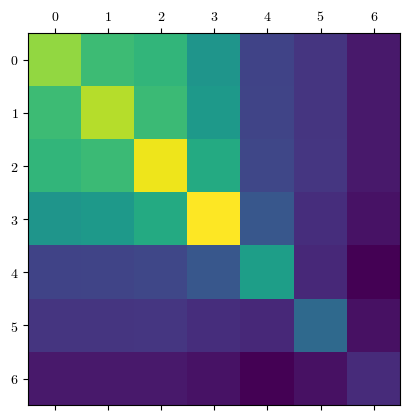

In [25]:
plt.matshow(cov_IA[0,0])

### Interpolate to get denser StoN estimates over rho

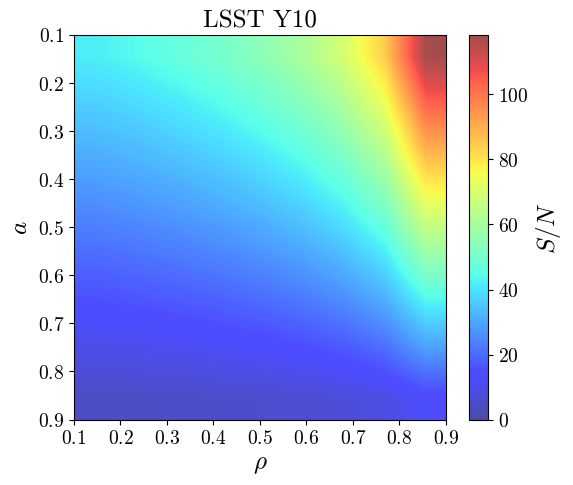

In [81]:
P, A = np.meshgrid(rho,a_vals)        
        
fig, ax = plt.subplots(figsize=[6,5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('LSST Y%d'%year, fontsize=18)

colors = cmr.take_cmap_colors('cmr.neutral', 3, cmap_range=(1.0, 0.0), return_fmt='hex')

cax = ax.imshow(np.flip(StoN, axis=0), extent=[rho[0],rho[-1],a_vals[0],a_vals[-1]], 
                aspect='auto', cmap='jet', vmin=0, interpolation='bilinear', alpha=0.7)

cbar = fig.colorbar(cax)
cbar.set_label(r'$S/N$', fontsize=18)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\rho$', fontsize=18)
ax.set_ylabel(r'$a$', fontsize=18)
plt.savefig('StoN_y%d_zs=%1.2f-%1.2f.pdf'%(year, zsmin, zsmax), bbox_inches='tight', dpi=300)

0.1 0.9


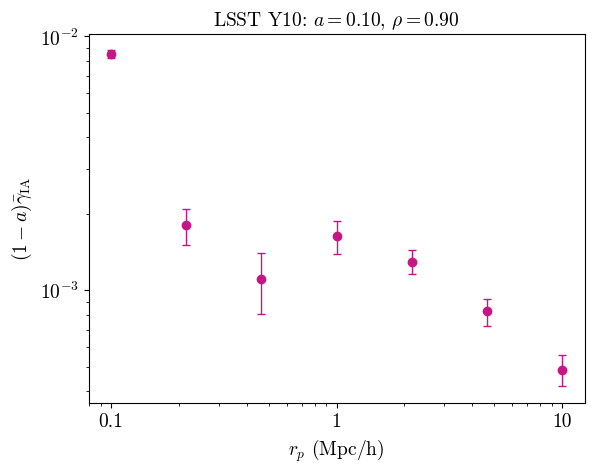

In [27]:
a = -1
p = -1
print(a_vals[a], rho[p])

plt.errorbar(r_p[:], -(1-a_vals[a])*yIA[:], np.sqrt(np.diag(cov_IA[a,p,:,:])), lw=0, marker='o', 
             elinewidth=1, capsize=3, label=r'Full covariance', color='mediumvioletred')
plt.title(r'LSST Y%d: $a = %1.2f$, $\rho = %1.2f$'%(year, a_vals[a], rho[p]), fontsize=14)
plt.xscale('log')
plt.axhline(c='black', ls='--')
plt.yscale('log')
plt.xlabel(r'$r_p$ (Mpc/h)', fontsize=14);
plt.ylabel(r'$(1-a)\bar{\gamma}_{\rm IA}$', fontsize=14);
plt.xticks([0.1,1,10],['0.1','1','10'], fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('y%d_gammaT_large_error.png'%year, bbox_inches='tight', dpi=300)

0.9


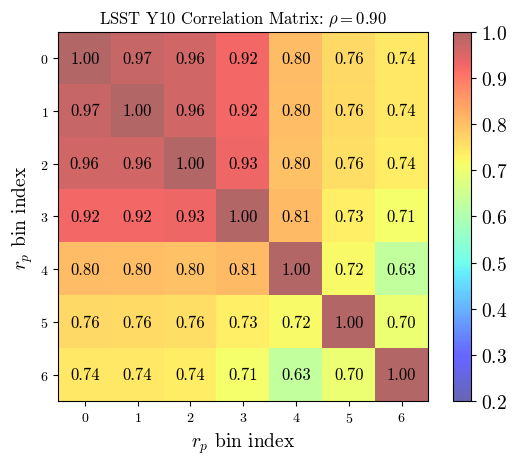

In [28]:
# Plot the correlation matrix

def covariance_to_correlation(covariance_matrix):
    # Calculate the diagonal matrix of standard deviations
    std_devs = np.sqrt(np.diag(covariance_matrix))
    # Calculate the inverse of the diagonal matrix of standard deviations
    inv_std_devs = 1 / std_devs
    # Calculate the correlation matrix
    correlation_matrix = np.multiply(np.multiply(inv_std_devs.reshape(-1, 1), covariance_matrix), inv_std_devs.reshape(1, -1))
    return correlation_matrix

a = 0
p = -1
print(rho[p])
corr_IA = covariance_to_correlation(cov_IA[a,p])

fig, ax = plt.subplots()
im = ax.imshow(corr_IA, cmap='jet', alpha=0.6, vmin=0.2)
texts = []
for i in range(corr_IA.shape[0]):
    for j in range(corr_IA.shape[1]):
        text = ax.annotate(f'{corr_IA[i, j]:.2f}',
                           xy=(j, i), ha='center', va='center',
                           color='black', fontsize=12)
    texts.append(text)
ax.set_title(r"LSST Y%d Correlation Matrix: $\rho = %1.2f$"%(year,rho[p]))
ax.set_xlabel(r'$r_p$ bin index', fontsize=14)
ax.set_ylabel(r'$r_p$ bin index', fontsize=14)
cbar = fig.colorbar(im)
cbar.ax.tick_params(labelsize=14)
plt.savefig('y%d_correlation_mat_rho=%1.2f.pdf'%(year, rho[p]), bbox_inches='tight', dpi=300)
plt.show()

### Fit simple scale dependent model using emcee

In [29]:
import emcee

# Define the model function
def broken_power_law(x, x_break, p1, p2, a1, a2):
    try:
        func = np.piecewise(x, [x < x_break, x >= x_break],
                            [lambda x: a1 * (x/x_break)**p1,
                             lambda x: a2 * (x/x_break)**p2])
    except:
        print(x, x_break, p1, p1, a1, a2)
    return func

def power_law(x, p1, a1):
    return a1 * x**p1

_, _, zleff = sp.zed.get_dndz_spec(gtype='lens', zlmin=zlmin, zlmax=zlmax, year=year)

# rp1h = sp.arcmin_to_rp((60*180)/1.4e4, zleff)
# rp2h = sp.arcmin_to_rp((60*180)/3e4, zleff)

rp1h = 0.3
rp2h = 0.75

# truncated power laws model
def trunc_power(rp, p1, p2, a1, a2):
    
    func = (a1*rp**p1)*(np.exp(-(rp/rp1h)**2)) + (a2*rp**p2)*(1-np.exp(-(rp/rp2h)**2))
    
    return func

In [30]:
# define log_likelihood function
def log_likelihood(free_params, rp, data_points, inv_cov):
    p1, p2, a1, a2 = free_params
    model = trunc_power(rp, p1, p2, a1, a2)
    x = data_points - model
    if np.isnan(-0.5 * np.dot(x, np.dot(inv_cov, x))):
        print(-0.5 * np.dot(x, np.dot(inv_cov, x)))
    return -0.5 * np.dot(x, np.dot(inv_cov, x))

In [31]:
# define priors. For now not using priors so function just returns 0
def log_prior(free_params):
    
    p1, p2, a1, a2 = free_params
    if -5 < p1 < 0 and -5 < p2 < 0 and 0 < a1 < 5 and 0 < a2 < 5:
        return 0
    
    return -np.inf

In [32]:
# log probability is combination of priors and likelihood
def log_probability(free_params, rp, data_points, inv_cov):
    
    lp = log_prior(free_params)
    if np.isnan(lp) or np.isinf(lp):
        return -np.inf
    
    ll = log_likelihood(free_params, rp, data_points, inv_cov)
    if np.isnan(ll):
        print(lp + ll)
        return -np.inf   
    return lp + ll

import itertools
def generate_combinations(arr1, arr2):
    combinations = []
    for element1, element2 in itertools.product(arr1, arr2):
        combinations.append([element1, element2])
    return combinations

poolsize = 60

iterables = generate_combinations(a_vals, rho)

print('%d iterations required'%(len(iterables)/poolsize))

1 iterations required


### Maximum likelihood fit find initialisation point

In [58]:
from scipy.optimize import minimize

a = 0
p = 0

# get data values
inv_cov = np.linalg.inv(cov_IA[a,p])
a_yIA = -(1-a_vals[a]) * yIA

np.random.seed(0)

nll = lambda *args: -log_likelihood(*args)
initial = np.array([-2, -1, (1-a_vals[a])*0.0006, (1-a_vals[a])*0.0036]) # 'true' values

soln = minimize(nll, initial, args=(r_p, a_yIA, inv_cov))
    
p1_ml, p2_ml, a1_ml, a2_ml = soln.x

print("Maximum likelihood estimates:")
print("p1 = {0:.3f}".format(p1_ml))
print("p2 = {0:.3f}".format(p2_ml))
print("a1 = {0:.5f}".format(a1_ml))
print("a2 = {0:.5f}".format(a2_ml))

Maximum likelihood estimates:
p1 = -2.001
p2 = -0.607
a1 = 0.00001
a2 = 0.00024


0.1 0.9


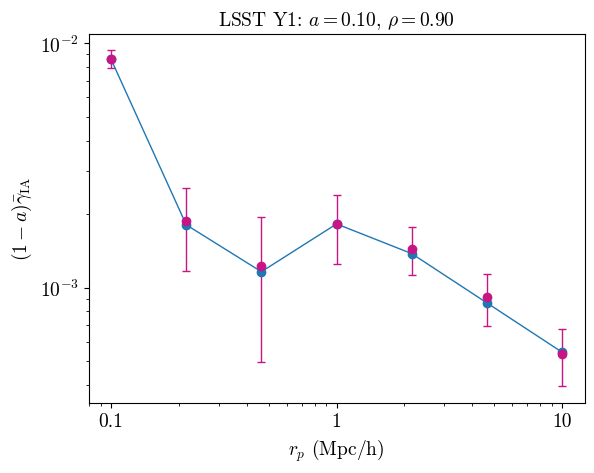

In [57]:
print(a_vals[a], rho[p])

model = trunc_power(r_p, p1_ml, p2_ml, a1_ml, a2_ml)

plt.errorbar(r_p[:], -(1-a_vals[a])*yIA[:], np.sqrt(np.diag(cov_IA[a,p,:,:])), lw=0, marker='o', 
             elinewidth=1, capsize=3, label=r'Full covariance', color='mediumvioletred')
plt.plot(r_p, model, lw=1, marker='o')
plt.title(r'LSST Y%d: $a = %1.2f$, $\rho = %1.2f$'%(year, a_vals[a], rho[p]), fontsize=14)
plt.xscale('log')
plt.axhline(c='black', ls='--')
plt.yscale('log')
#plt.ylim([1e-4,2e-2])
plt.xlabel(r'$r_p$ (Mpc/h)', fontsize=14);
plt.ylabel(r'$(1-a)\bar{\gamma}_{\rm IA}$', fontsize=14);
plt.xticks([0.1,1,10],['0.1','1','10'], fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('y%d_gammaT_large_error.png'%year, bbox_inches='tight', dpi=300)

In [35]:
print(soln.x[0])

-1.8520751202097954


In [36]:
def converge_that_chain(a_rho, progress=True):
    
    # unpack parameters from list
    a = a_rho[0]
    p = a_rho[-1]
    
    # path to nobackup sym link for chain storage
    dat_dir = '/home/b7009348/WGL_project/LSST-SRD-data/LSST_forecast_fits/'
        
    # file name to save chains to during the run
    in_prog_file = dat_dir+'in_progress_chains/y%d_a=%1.2f_p=%1.2f_sampler.pkl'%(year,a,p)
    
    # file name to save converged chains
    conv_file = dat_dir+'converged_chains/y%d_a=%1.2f_p=%1.2f_chain.npz'%(year,a,p)
    
    # check to see if a converged chain already exists, if so read it and get S/N from there
    if os.path.exists(conv_file):
        
        if os.path.exists(in_prog_file):
            os.remove(in_prog_file)
            
        print('Found previously converged chain for a=%1.2f, p=%1.2f. Reading data...'%(a,p))
        with np.load(dat_dir+'converged_chains/y%d_a=%1.2f_p=%1.2f_chain.npz'%(year,a,p)) as f:
            StoN = f['StoN']
        
        # return now to avoid running uneccessary chains
        return StoN
    
    # locate a and rho value indices
    i = np.where(a_vals == a)[0][0]
    j = np.where(rho == p)[0][0]
    
    # get data values
    inv_cov = np.linalg.inv(cov_IA[i,j])
    a_yIA = -(1-a) * yIA

    # number of walkers and dimension of parameter space
    nwalkers = 32
    ndim = 4
    
    # seed must be the same for all runs
    np.random.seed(0)
    
    # initialise sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(r_p, a_yIA, inv_cov))
    
    # initialise parameters for loop
    converged = False
    
    # check for previous run of chain, if it exists, read walker positions in
    if os.path.exists(in_prog_file):
        print('Found in progress chain for a=%1.2f, p=%1.2f. Reading data...'%(a,p))
        # Load the saved sampler state
        with open(in_prog_file, 'rb') as f:
            sampler = pickle.load(f)
            coords=None
    else:
        # set initial positions of walkers     
        nll = lambda *args: -log_likelihood(*args)
        initial = np.array([-2, -1, (1-a)*0.0006, (1-a)*0.0036]) # 'true' values

        soln = minimize(nll, initial, args=(r_p, a_yIA, inv_cov))
        
        # initialise based on max likelihood estimates
        p1_init = soln.x[0] + 1e-2 * np.random.randn(nwalkers,1)
        p2_init = soln.x[1] + 1e-3 * np.random.randn(nwalkers,1)
        a1_init = soln.x[2] + (1-a)*1e-5 * np.random.randn(nwalkers,1) # need to scale amplitude spread by a to avoid error at start of chain
        a2_init = soln.x[3] + (1-a)*1e-4 * np.random.randn(nwalkers,1)
        
        coords = np.hstack([p1_init, p2_init, a1_init, a2_init])
    
    # number of steps to run between convergence checks
    chain_len = 10000
    
    while converged == False:
        
        # Now we'll sample indefinitely* until convergence steps
        sampler.run_mcmc(coords, nsteps=chain_len, progress=progress, store=True)
        
        # Save the sampler state
        with open(in_prog_file, 'wb') as f:
            pickle.dump(sampler, f)

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)

        # Check convergence and exit if converged
        converged = np.all(tau * 50 < sampler.iteration)
        if converged:
            print('Chain for a=%1.2f, p = %1.2f covereged with %d steps'%(a,p,sampler.iteration))
            break
        
        # if we go over 1e7 storage on nobackup is going to become a concern
        if sampler.iteration > 10000000:
            print('Warning! chain still not converged for a=%1.2f, p = %1.2f after %d steps'%(a,p,sampler.iteration))
            with open(in_prog_file, 'wb') as f:
                pickle.dump(sampler, f)
            return -1
        
    # compute auto_corr time once more for good measure (should give error if not converged)
    try:
        tau = sampler.get_autocorr_time()
    except:
        # check just in case something has gone horribly wrong - MPI is bad at giving errors back
        print('Warning! Something has gone wrong in checking convergence')
    
    # discard steps for burn in and thin chain
    burnin = int(2 * np.max(tau))
    thin = int(0.5 * np.min(tau))
    flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
    log_probs = sampler.get_log_prob(discard=burnin, thin=thin, flat=True)
    accept_frac = np.mean(sampler.acceptance_fraction)
    if accept_frac < 0.1:
        print('Warning! Acceptance fraction is very low:',accept_frac)
    
    # calculate 1-halo scale dependence SNR
    mcmc = np.percentile(flat_samples[:,0], [16, 50, 84])
    sigma = abs(mcmc[-1] - mcmc[0])
    StoN = abs(mcmc[1]/sigma)
    
    # save chain and SNR to npz file, we don't need to pickle the whole sampler once it has converged
    np.savez(conv_file, StoN=StoN, chain=flat_samples, log_probs=log_probs, accept_frac=accept_frac)
    
    # remove pickled samplers as they are quite large and no longer needed ONLY if they exist
    os.remove(in_prog_file)
       
    return abs(mcmc[1]/sigma)

In [37]:
print(iterables[-1])
converge_that_chain(iterables[-1])

[0.1, 0.9]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 889.61it/s]


Chain for a=0.10, p = 0.90 covereged with 20000 steps


10.01047325051138

In [38]:
global wrap_for_mp
def wrap_for_mp(iterable):
    return converge_that_chain(a_rho=iterable, progress=False), iterable

# preallocate list for outputs
StoN_list = [0] * len(iterables)

# open multiprocess pool in with statement so it closes after it's complete
with mp.Pool(poolsize) as p:
    # output values and process ID (imap should ensure correct order)
    StoN_list, order = zip(*p.imap(wrap_for_mp, iterables))

# run quick test to ensure order of outputs was preserved
check_order = list(order)
if check_order == iterables:
    print('Order preserved')
else:
    print('Order scrambled, data corrupted')
    exit()

Chain for a=0.90, p = 0.40 covereged with 30000 steps
Chain for a=0.40, p = 0.20 covereged with 30000 steps
Chain for a=0.50, p = 0.80 covereged with 30000 steps
Chain for a=0.90, p = 0.30 covereged with 30000 steps
Chain for a=0.60, p = 0.40 covereged with 30000 steps
Chain for a=0.40, p = 0.60 covereged with 30000 steps
Chain for a=0.90, p = 0.20 covereged with 30000 steps
Chain for a=0.50, p = 0.60 covereged with 40000 steps
Chain for a=0.50, p = 0.50 covereged with 40000 steps
Chain for a=0.40, p = 0.90 covereged with 30000 steps
Chain for a=0.90, p = 0.10 covereged with 30000 steps
Chain for a=0.70, p = 0.40 covereged with 40000 steps
Chain for a=0.40, p = 0.80 covereged with 30000 steps
Chain for a=0.60, p = 0.60 covereged with 30000 steps
Chain for a=0.40, p = 0.30 covereged with 40000 steps
Chain for a=0.60, p = 0.20 covereged with 40000 steps
Chain for a=0.90, p = 0.50 covereged with 40000 steps
Chain for a=0.40, p = 0.10 covereged with 30000 steps
Chain for a=0.40, p = 0.50 c

-1.7885953086417763
-1.8074036887788258
4.648962100395275
-1.6117301152926173 -2.000505857006053
4.60058361861512


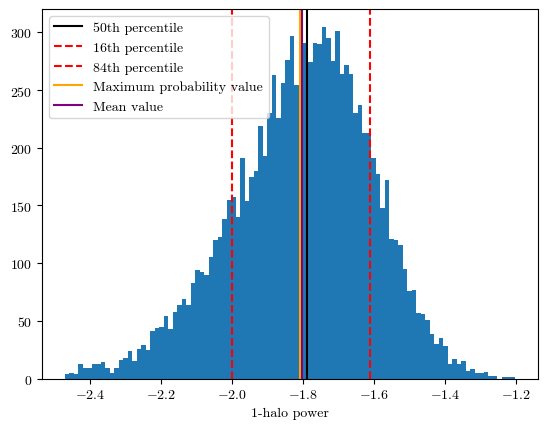

In [39]:
with np.load('/home/b7009348/WGL_project/LSST-SRD-data/LSST_forecast_fits/converged_chains/y1_a=0.10_p=0.90_chain.npz') as f:
    
    chain = f['chain']
    log_probs = f['log_probs']
    sn = f['StoN']
    max_prob = chain[np.where(log_probs == np.max(log_probs))[0][0],0]
    mcmc = np.percentile(chain[:,0], [16, 50, 84])
       
plt.hist(chain[:,0], bins=100);
plt.axvline(np.percentile(chain[:,0],50), color='black', label='50th percentile')
plt.axvline(np.percentile(chain[:,0],16), color='red', ls='--', label='16th percentile')
plt.axvline(np.percentile(chain[:,0],84), color='red', ls='--', label='84th percentile')
plt.axvline(max_prob, color='orange', label='Maximum probability value')
plt.axvline(np.average(chain[:,0]), color='purple', label='Mean value')
plt.xlabel('1-halo power')
plt.legend()

print(np.percentile(chain[:,0],50))
print(max_prob)
print(abs(max_prob/abs(mcmc[-1] - mcmc[0])))
print(mcmc[-1], mcmc[0])
print(sn)

-0.3749109728113841
-1.517727774448474
1.854014355216693
-0.09695095898024121 -0.915568015627079
0.457980895666978


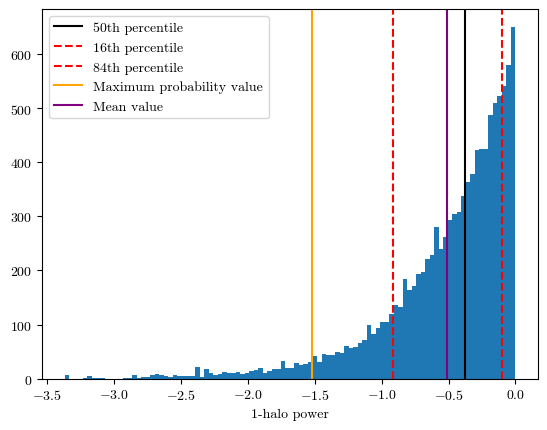

In [72]:
with np.load('/home/b7009348/WGL_project/LSST-SRD-data/LSST_forecast_fits/converged_chains/y1_a=0.90_p=0.10_chain.npz') as f:
    
    chain = f['chain']
    log_probs = f['log_probs']
    sn = f['StoN']
    max_prob = chain[np.where(log_probs == np.max(log_probs))[0][0],0]
    mcmc = np.percentile(chain[:,0], [16, 50, 84])
       
plt.hist(chain[:,0], bins=100);
plt.axvline(np.percentile(chain[:,0],50), color='black', label='50th percentile')
plt.axvline(np.percentile(chain[:,0],16), color='red', ls='--', label='16th percentile')
plt.axvline(np.percentile(chain[:,0],84), color='red', ls='--', label='84th percentile')
plt.axvline(max_prob, color='orange', label='Maximum probability value')
plt.axvline(np.average(chain[:,0]), color='purple', label='Mean value')
plt.xlabel('1-halo power')
plt.legend()

print(np.percentile(chain[:,0],50))
print(max_prob)
print(abs(max_prob/abs(mcmc[-1] - mcmc[0])))
print(mcmc[-1], mcmc[0])
print(sn)

[-0.3749109728113841, -1.001244293981816, 0.0003905258440774734, 0.0004507598162478728]


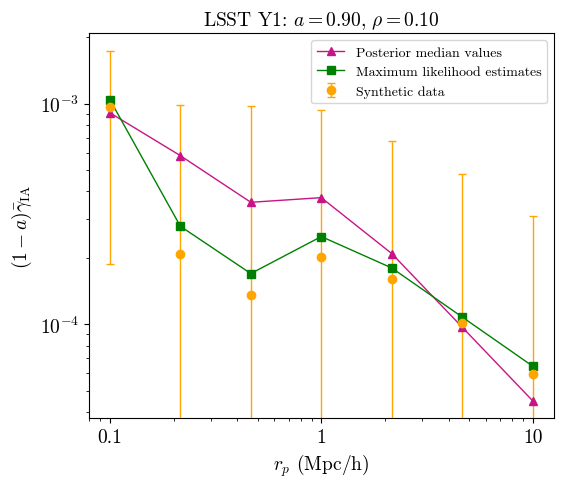

In [73]:
fits = [np.percentile(chain[:,i], 50) for i in range(4)]
max_like = [chain[np.where(log_probs == np.max(log_probs))[0][0],i] for i in range(4)]
print(fits)

i = np.where(a_vals == 0.9)[0][0]
j = np.where(rho == 0.1)[0][0]

model = trunc_power(r_p, *fits)
model_ml = trunc_power(r_p, *max_like)

plt.figure(figsize=[6,5])
plt.errorbar(r_p[:], -(1-a_vals[i])*yIA[:], np.sqrt(np.diag(cov_IA[i,j,:,:])), lw=0, marker='o', 
             elinewidth=1, capsize=3, color='orange', label='Synthetic data')
plt.plot(r_p, model, lw=1, marker='^', color='mediumvioletred', label='Posterior median values')
plt.plot(r_p, model_ml, lw=1, marker='s', color='green',label='Maximum likelihood estimates')
plt.legend()
plt.title(r'LSST Y%d: $a=%1.2f, \, \rho=%1.2f$'%(year, a_vals[i], rho[j]), fontsize=14)
plt.xscale('log')
plt.axhline(c='black', ls='--')
plt.yscale('log')
#plt.ylim([1e-5,5e-3])
plt.xlabel(r'$r_p$ (Mpc/h)', fontsize=14);
plt.ylabel(r'$(1-a)\bar{\gamma}_{\rm IA}$', fontsize=14);
plt.xticks([0.1,1,10],['0.1','1','10'], fontsize=14);
plt.yticks(fontsize=14);
plt.savefig('y%d_gammaT_large_error.pdf'%year, bbox_inches='tight', dpi=300)

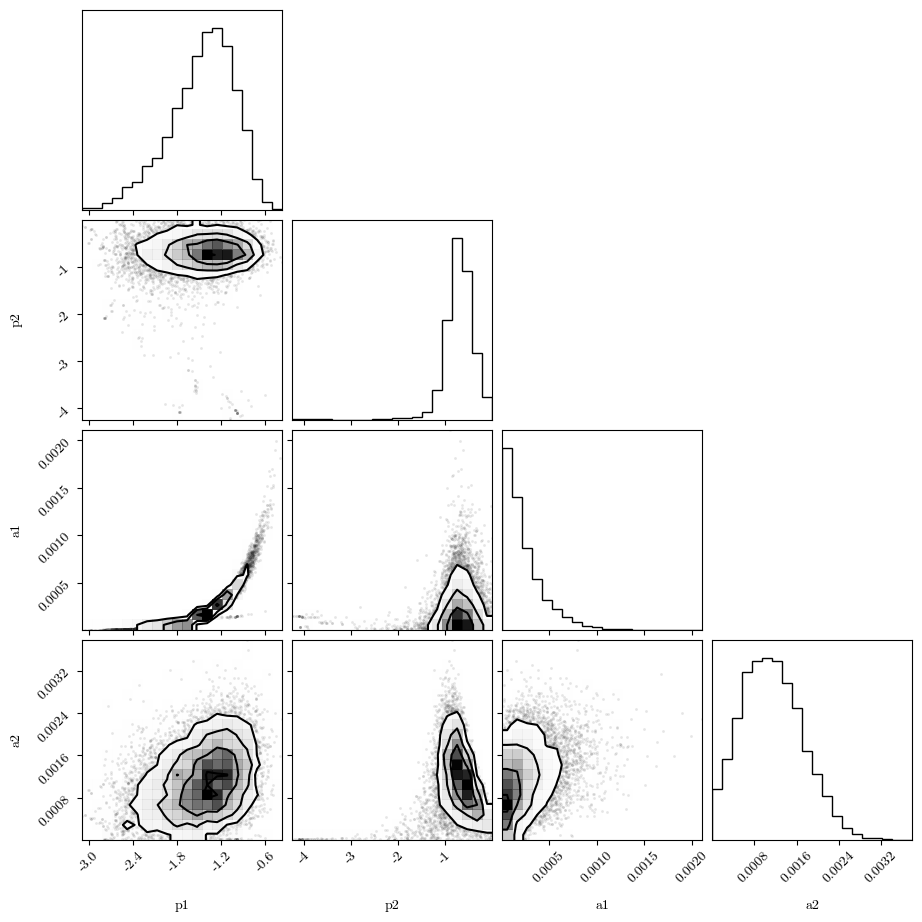

In [42]:
import corner
labels = ["p1", "p2", "a1", "a2"]
fig = corner.corner(
    chain, labels=labels
);

In [43]:
#print(iterables)
StoN_b1 = np.asarray(StoN_list).reshape(len(a_vals), len(rho))
print(np.shape(StoN_b1))
print(abs(StoN_b1))

(9, 9)
[[ 0.70265432  0.72265071  0.77394171  0.86534419  0.89358204  1.00125802
   1.13705526  1.2540909   1.62227996]
 [ 1.35852068  1.40803285  1.52754723  1.5740589   1.63470743  1.77422965
   1.8319385   2.10810036  2.60381687]
 [ 1.87314416  1.93314389  2.0724799   2.24482809  2.17225617  2.32916288
   2.60967956  3.0290563   3.57825292]
 [ 2.37485253  2.32692429  2.51869732  2.73125181  2.74430878  3.05739962
   3.25213137  3.66718823  4.65248889]
 [ 2.80305706  2.92308629  3.06100823  3.20385167  3.27767047  3.59424007
   3.92072149  4.5782778   5.61953501]
 [ 3.19592126  3.51500852  3.48095112  3.70365333  4.03317484  4.08757671
   4.43140075  5.26273695  6.79690166]
 [ 3.79834645  3.79837108  3.94559931  4.14597168  4.51449222  4.84583461
   5.29804484  5.88203366  7.81725274]
 [ 4.22480352  4.25348113  4.58196966  4.57799214  5.02225963  5.49992092
   6.00745803  6.74599217  8.96327292]
 [ 4.73627451  4.77146369  5.11777847  5.4454588   5.70720421  5.99659244
   6.64433381  

In [44]:
np.savez('generated_data/scale_dependence_SNR.npz', SNR = StoN_b1)

# CHECK: Is linear ok for this?
interp = interp1d(rho, StoN_b1, axis=1)

StoN_dense = interp(rho_dense)

NameError: name 'rho_dense' is not defined

In [ ]:
P, A = np.meshgrid(rho_dense,a_vals)        
        
fig, ax = plt.subplots(figsize=[6,5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('LSST Y%d'%year, fontsize=18)

colors = cmr.take_cmap_colors('cmr.neutral', 3, cmap_range=(1.0, 0.0), return_fmt='hex')

sig = ax.contour(P,A,StoN_dense,[1,2,3], linestyles='solid', linewidths=2, colors=colors)

fmt = {}
strs = [r'$1\sigma$', r'$2\sigma$', r'$3\sigma$']
for l, s in zip(sig.levels, strs):
    fmt[l] = s

cax = ax.imshow(np.flip(StoN_dense, axis=0), extent=[rho_dense[0],rho_dense[-1],a_vals[0],a_vals[-1]], 
                aspect='auto', cmap='jet', vmin=0, interpolation='bilinear')

cbar = fig.colorbar(cax)
cbar.set_label(r'$S/N$', fontsize=18)
cbar.ax.tick_params(labelsize=14)
ax.set_xlabel(r'$\rho$', fontsize=18)
ax.set_ylabel(r'$a$', fontsize=18)
locs = []
ax.clabel(sig, sig.levels, inline=True, fmt=fmt, fontsize=18, manual=locs)
#plt.savefig('StoN_y%d_zs=%1.2f-%1.2f.png'%(year, zsmin, zsmax), bbox_inches='tight', dpi=300)